In [1]:
%cd /content/drive/My Drive/AI4T

/content/drive/My Drive/AI4T


In [3]:
import math, random
import gym
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import signal
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
%matplotlib inline
import matplotlib.pyplot as plt


torch.manual_seed(42)
cwd = '/content/drive/My Drive/AI4T'

# Load from orderbook/message


In [6]:
def add_readble_time(start_date, df):
    df = df.copy()
    df.insert(0, "date", [start_date + timedelta(seconds=i) for i in df["time"]])
    return df

def compute_R(data_open, k):  
    # computes the rolling window's sum backwards
    m_pos = data_open.rolling(window = k).mean()
    
    # computes the rolling window's sum forwards 
    m_neg = data_open.iloc[::-1].rolling(window = k).mean().iloc[::-1]   
    return (m_pos - m_neg)/m_neg.fillna(1)

def make_ohlc(price, size, resample_time, k):  
    # computes price in USD and creates ohlc
    price_data = price.apply(lambda x: x/10000)
    price_data = price_data.resample(resample_time).ohlc()
    price_data = price_data.fillna(method = 'ffill')
    
    # volumes
    vol_data = size.resample(resample_time).sum()
    vol_data = pd.DataFrame(vol_data.rename('volume').fillna(0))
    
    # add R values
    df = pd.concat([price_data, vol_data], axis = 1)
    # df['R'] = compute_R(df['open'], k)  
    return df


# load data
order_cols =[]
for i in range(1, 2):
     order_cols.extend(["sell_" + str(i), "vsell_" + str(i), "buy_" + str(i), "vbuy_" + str(i)])
        
col_names = {"orderbook": order_cols,
            "message": ["time", "event_type", "order_id", "size", "price", "direction"]}

messages = pd.read_csv(cwd + '/data/AMZN/AMZN_2012-06-21_34200000_57600000_message_1.csv', names=col_names["message"])
orderbook = pd.read_csv(cwd + '/data/AMZN/AMZN_2012-06-21_34200000_57600000_orderbook_1.csv', names=col_names["orderbook"])

# merge orderbook and messages
data = messages.copy()
data[col_names["orderbook"]] = orderbook

# set correct date format
start_date = datetime.strptime("21.06.2012", "%d.%m.%Y")
data = add_readble_time(start_date, data)

# consider only executed orders
executed = data[(data["event_type"].isin([4,5]))]
executed.index = executed["date"]

# k to compute the R value
k=5
times = ['1s', '10s', '1Min', '10Min'] 

# list with different ohlcv
out = [ make_ohlc(price = executed['price'], 
                  size = executed['size'], 
                  resample_time = time, 
                  k = k) for time in times]

# save output
# for el, time  in zip(out, times):
#     el.to_csv(cwd + '/data/' + time + '_AAPL.csv')

df_1s = out[0].copy()
df_10s = out[0].copy()
df_1m = out[0].copy()
df_10m = out[0].copy()

# Load OHLCV

In [7]:
# gold from aug 103 to mar 2019
df = pd.read_csv(cwd + '/data/GC=F.csv') 
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close']

for col in cols:
  df[col].fillna(method = 'ffill', inplace = True)
  
df.Volume.fillna(0, inplace = True)

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-08-13,1331.900024,1339.099976,1320.199951,1321.199951,1321.199951,209.0
1,2013-08-14,1317.699951,1336.300049,1317.699951,1334.000000,1334.000000,333.0
2,2013-08-15,1340.099976,1369.599976,1319.900024,1361.599976,1361.599976,235.0
3,2013-08-16,1366.800049,1378.900024,1361.000000,1371.699951,1371.699951,175.0
4,2013-08-18,1366.800049,1378.900024,1361.000000,1371.699951,1371.699951,0.0


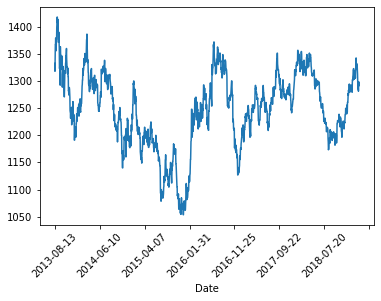

In [9]:
df.set_index(df['Date']).Open.plot(rot = 45)


# evolution strategy

In [12]:
import seaborn as sns
import random
sns.set()



import pkg_resources
import types
import time 


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))


torch==1.7.0+cu101
seaborn==0.11.0
scipy==1.4.1
pandas==1.1.4
numpy==1.18.5
matplotlib==3.2.2
gym==0.17.3


In [ ]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights



class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, close





close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 3000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)





In [ ]:
states_buy, states_sell, total_gains, invest, close = agent.buy()

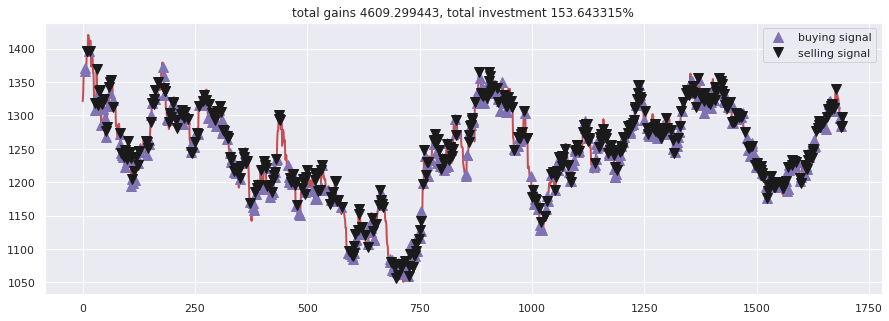

In [15]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()



In [16]:
# check if the agent sold more than it has
history = [0 for _ in range(len(df))]
for buy in states_buy:
  history[buy] = 1
for sell in states_sell:
  history[sell] = -1

df['Order type Agent'] = history

t = 0
for idx in range(len(history)):
  t = t + history[idx]
  if t < 0:
    break

print(t, idx)


0 1694


In [ ]:
# df.to_csv('test.csv')

In [ ]:
df['Price Agent'] = close

In [ ]:
v = [abs(el) for el in history]

In [ ]:
df['Volume Agent'] = v

In [ ]:
df.set_index('Date')[df.columns[-3:]].head()